# Introduction

This notebook solves the steady state Navier Stokes equations in 2D discretised using the Finite Volume Method, for a fluid flowing through a rectangular channel. Material properties of fluid, geometry of channel and the mesh is selected by the user. 

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve


# Helper Functions

## Contour Plot

In [8]:
def contourPlot(Nx,Ny,Lx,Ly,value,valueName,unit):
    '''
    Creates a contour plot for 'value'
    Arguments:
        Lx, Ly: Dimensions of plate in x and y direction - unit: (m)
        Nx, Ny: Number of cells for mesh in x and y directions - no unit
        value: column vector of length M that represents a solution variable
        valueName: name for the value
        unit: unit for the value
    '''
    dx = Lx/Nx
    dy = Ly/Ny
    X,Y = np.meshgrid(np.arange(0,Lx,dx),np.arange(0,Ly,dy))#mesh grid for full mesh
    plot = np.reshape(value, (Ny, Nx))
    plt.figure()
    plt.contourf(X,Y,plot,cmap='inferno')
    plt.colorbar(label="%s %s"%(valueName,unit))
    plt.title("%s Distribution"%valueName, fontsize=15)
    plt.ylabel("Ly (m)")
    plt.xlabel("Lx (m)")

## Assemble Coefficient Matrix


In [3]:
def assemble_matrix(Nx,Ny,Lx,Ly,mu,rho,scaleFactor,v):
    '''
    Builds the coefficient matrix (A) for the problem

    Arguments:
        Lx, Ly: Dimensions of plate in x and y direction - unit: (m)
        Nx, Ny: Number of cells for mesh in x and y directions - no unit
        mu: dynamic viscosity of fluid - unit: (Pa.s)
        rho: density of fluid - unit: (kg/m^3)
        scaleFactor: scale factor for smoothing coefficient in Rhie-Chow term - no unit
        v: solution vector (u, v, p) of last iteration... used for convection term
    
    Returns:
        A: Coefficient matrix for current iteration
        b: Source vector for current iteration
        D: Smoothing coefficient
    '''
    
    '''
    Some helpful constants
    '''
    g = 9.81#gravity
    eqs = 3 #3 equations (momentum x, y and continuity)

    #grid spacing
    dx = Lx/Nx
    dy = Ly/Ny

    #total number of cells
    M = int(Nx*Ny)

    #get indices of corner cells
    botright = eqs*(Nx-1)
    topleft = eqs*(Nx*(Ny-1))
    topright = eqs*(Nx*Ny-1)

    '''
    Coefficients
    '''
    #X-MOM and Y-MOM
    #velocities
    ax = mu*dy/dx #a_E and a_W
    ay = mu*dx/dy #a_N and a_S
    ap = -2*(ax+ay) #a_P

    #CONTINUITY
    #velocity coefficients in continuity equations and pressure gradient coefficients in momentum equation
    ex = dy/2
    ey = dx/2

    #smoothing term
    D = scaleFactor*dx*dy/(ap)

    #Implicit Pressure Gradient
    Sx = (D*dy)/dx
    Sy = (D*dx)/dy
    Sp = -2*(Sx+Sy)

    '''
    Initialisations
    '''
    #Initialise coefficient matrix
    A = np.zeros((eqs*M, eqs*M))
     #Initialise source vector
    b = np.zeros((eqs*M, 1))

    #CSR Matrix
    internal = (Nx-2)*(Ny-2)
    corners = 4
    horizontal_sides = (Nx-2)*2
    vertical_side = (Ny-2)
    numNonZeros = int(20*horizontal_sides+19*vertical_side+20*vertical_side+66+internal*23) #20 by inlet,bot,top, 
    #19 by outlet, 66 for corners, 23 for internal
    data = np.zeros((numNonZeros))
    row_idx = np.zeros((numNonZeros ))
    col_idx = np.zeros((numNonZeros ))
    coeffi=0

    '''
    Build Linear System (A and b)
    '''
    #Loop through each cell i
    for i in range(0, eqs*M, eqs):
        
        #CORNERS
        #bottom left
        if i == 0:
            #convection coeffs
            ge = -rho*dy*(v[i+3]+v[i])/4 #Ae(vex+vpx)/4
            gn = -rho*dx*(v[i+eqs*Nx+1]+v[i+1])/4 #An(vny+vpy)/4
            
            #X-MOM
            #-------#
            #RHS
            b[i] = -2*ax*vin[0]+dy*vin[0]**2*rho
            #LHS
            
            #vpx
            data[coeffi] = -3*ax-3*ay+ge+gn
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vex
            data[coeffi] = ax+ge 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            #vnx
            data[coeffi] = ay+gn
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            #Pe
            data[coeffi] = -ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            #Pp
            data[coeffi] = ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = -2*ax*vin[1]+dy*vin[0]*vin[1]*rho
            #LHS
            
            #vpy
            data[coeffi] = -3*ax-3*ay +ge+gn
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vey
            data[coeffi] = ax +ge 
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            #vny
            data[coeffi] = ay +gn
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -ey
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = ey  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
            #CONTINUITY
            #-------#
            #LHS
            
            #vpx
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            #vpy
            data[coeffi] = ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vex
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pn
            data[coeffi] = Sy  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = Sp/2  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
           
        #bottom right
        elif i == botright:
            
            gw = rho*dy*(v[i-3]+v[i])/4 #-Aw(vwx+vpx)/4
            gn = -rho*dx*(v[i+eqs*Nx+1]+v[i+1])/4 #An(vny+vpy)/4
            #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            
            #vpx
            data[coeffi] = -ax-3*ay+gw+gn-dy*v[i]*rho 
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = ax+gw  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            #vnx
            data[coeffi] = ay+gn  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = (4/3)*ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1

            #Y-MOM
            #-------#
            #RHS
            b[i+1] = 0
            #LHS
            
            #vpy
            data[coeffi] = -ax-3*ay+gw+gn-dy*v[i]*rho 
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax +gw 
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            #vny
            data[coeffi] = ay +gn 
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -ey
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = ey  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
            #CONTINUITY
            #-------#
 
            #LHS
            
            #vpx
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            #vpy
            data[coeffi] = ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
#             #Pw
#             data[coeffi] = Sx
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i-1
            
#             coeffi+=1
            
#             #Pn
#             data[coeffi] = Sy  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i+eqs*Nx+2
            
#             coeffi+=1
            
#             #Pp
#             data[coeffi] = -3*Sx-Sy  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i+2
            
#             coeffi+=1
            
        #Top Left
        elif i == topleft:
            
            ge = -rho*dy*(v[i+3]+v[i])/4 #Ae(vex+vpx)/4
            gs = rho*dx*(v[i-eqs*Nx+1]+v[i+1])/4 #-As(vsy+vpy)/4
            #X-MOM
            #-------#
            #RHS
            b[i] = -2*ax*vin[0]+dy*rho*vin[0]**2
            #LHS
            
            #vpx
            data[coeffi] = -3*ax-3*ay+ge+gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vex
            data[coeffi] = ax +ge 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            #vsx
            data[coeffi] = ay +gs 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pe
            data[coeffi] = -ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pp
            data[coeffi] = ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            coeffi+=1

            #Y-MOM
            #-------#
            #RHS
            b[i+1] = -2*ax*vin[1]+dy*rho*vin[0]*vin[1]
            #LHS
            
            #vpy
            data[coeffi] = -3*ax-3*ay+ge+gs
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vey
            data[coeffi] = ax +ge
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            #vsy
            data[coeffi] = ay +gs
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Ps
            data[coeffi] = ey
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = -ey  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1
     
            #CONTINUITY
            #-------#

            #LHS
            
            #vpx
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            #vpy
            data[coeffi] = -ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vex
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Ps
            data[coeffi] = Sy  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = Sp/2  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
     
        #top right
        elif i == topright:
            
            gw = rho*dy*(v[i-3]+v[i])/4 #-Aw(vwx+vpx)/4
            gs = rho*dx*(v[i-eqs*Nx+1]+v[i+1])/4 #-As(vsy+vpy)/4
            #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            
            #vpx
            data[coeffi] = -ax-3*ay-rho*dy*v[i]+gw+gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = ax+gw
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            #vsx
            data[coeffi] = ay+gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = (4/3)*ex
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
               
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = 0
            #LHS
            
            #vpy
            data[coeffi] = -ax-3*ay-rho*dy*v[i]+gw+gs
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax +gw 
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            #vsy
            data[coeffi] = ay +gs 
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Ps
            data[coeffi] = ey
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = -ey  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1

            #CONTINUITY
            #-------#

            #LHS
            
            #vpx
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            #vpy
            data[coeffi] = -ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
#             #Pw
#             data[coeffi] = Sx
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i-1
            
#             coeffi+=1
            
#             #Ps
#             data[coeffi] = Sy  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i-eqs*Nx+2
            
#             coeffi+=1
            
#             #Pp
#             data[coeffi] = -3*Sx-Sy  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i+2
            
#             coeffi+=1
            
        #SIDES
        #bottom
        elif 0 < i < botright:
            
            ge = -rho*dy*(v[i+3]+v[i])/4 #Ae(vex+vpx)/4
            gw = rho*dy*(v[i-3]+v[i])/4 #-Aw(vwx+vpx)/4
            gn = -rho*dx*(v[i+eqs*Nx+1]+v[i+1])/4 #An(vny+vpy)/4
            #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            #vpx
            data[coeffi] = -2*ax-3*ay +ge+gw+gn
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = ax +gw
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = ax +ge
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vnx
            data[coeffi] = ay +gn 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = -ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = 0
            #LHS
            #vpy
            data[coeffi] = -2*ax-3*ay  +ge+gw+gn
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax +gw
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            
            #vey
            data[coeffi] = ax +ge
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            #vny
            data[coeffi] = ay +gn
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -ey
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = ey  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1
    
            #CONTINUITY
            #-------#

            #LHS
            
            #vpy
            data[coeffi] = ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #Pw
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pn
            data[coeffi] = Sy  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = -2*Sx-Sy  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
           
        #top
        elif topleft < i < topright:
            
            ge = -rho*dy*(v[i+3]+v[i])/4 #Ae(vex+vpx)/4
            gw = rho*dy*(v[i-3]+v[i])/4 #-Aw(vwx+vpx)/4
            gs = rho*dx*(v[i-eqs*Nx+1]+v[i+1])/4 #-As(vsy+vpy)/4
            #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            
            #vpx
            data[coeffi] = -2*ax-3*ay+ge+gw+gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = ax +gw
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = ax +ge
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vsx
            data[coeffi] = ay +gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = -ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = 0
            #LHS
            
            #vpy
            data[coeffi] = -2*ax-3*ay +ge+gw+gs 
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax  +gw
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            
            #vey
            data[coeffi] = ax +ge
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            #vsy
            data[coeffi] = ay +gs 
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Ps
            data[coeffi] = ey
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            #Pp
            data[coeffi] = -ey  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+2
            
            coeffi+=1

            #CONTINUITY
            #-------#

            #LHS
            
            #vpy
            data[coeffi] = -ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = ex
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #Pw
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Ps
            data[coeffi] = Sy  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = -2*Sx-Sy  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
        #left / Inlet
        elif i in range(eqs*Nx,topleft,eqs*Nx):
            
            ge = -rho*dy*(v[i+3]+v[i])/4 #Ae(vex+vpx)/4
            gn = -rho*dx*(v[i+eqs*Nx+1]+v[i+1])/4 #An(vny+vpy)/4
            gs = rho*dx*(v[i-eqs*Nx+1]+v[i+1])/4 #-As(vsy+vpy)/4
            #X-MOM
            #-------#
            #RHS
            b[i] = -2*ax*vin[0]+rho*dy*vin[0]**2
            #LHS
            
             #vpx
            data[coeffi] = -3*ax-2*ay+ge+gn+gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vex
            data[coeffi] = ax +ge
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vnx
            data[coeffi] = ay+gn
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            
            #vsx
            data[coeffi] = ay + gs 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pe
            data[coeffi] = -ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pp
            data[coeffi] = ex  
            row_idx[coeffi] = i
            col_idx[coeffi] = i+2
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = -2*ax*vin[1]+rho*dy*vin[0]*vin[1]
            #LHS
            #vpy
            data[coeffi] = -3*ax-2*ay +ge+gn+gs
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vey
            data[coeffi] = ax +ge
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            
            #vny
            data[coeffi] = ay +gn
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = ay +gs
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Ps
            data[coeffi] = ey  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #Pn
            data[coeffi] = -ey  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1

            #CONTINUITY
            #-------#

            #LHS
            
            #vpx
            data[coeffi] = ex  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #vex
            data[coeffi] = ex 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #Pe
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pn
            data[coeffi] = Sy
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Ps
            data[coeffi] = Sy  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = -Sx-2*Sy  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
    
        #right / Outlet
        elif i in range(botright+eqs*Nx,topright,eqs*Nx):
            
            gw = rho*dy*(v[i-3]+v[i])/4 #-Aw(vwx+vpx)/4
            gn = -rho*dx*(v[i+eqs*Nx+1]+v[i+1])/4 #An(vny+vpy)/4
            gs = rho*dx*(v[i-eqs*Nx+1]+v[i+1])/4 #-As(vsy+vpy)/4
            #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            
             #vpx
            data[coeffi] = -ax-2*ay +gw+gn+gs-rho*dy*v[i] 
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = ax +gw
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vnx
            data[coeffi] = ay +gn
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            
            #vsx
            data[coeffi] = ay +gs
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = (4/3)*ex 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
    
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = 0
            #LHS
            
            #vpy
            data[coeffi] = -ax-2*ay+gw+gn+gs-rho*dy*v[i]  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax +gw 
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            
            #vny
            data[coeffi] = ay +gn
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = ay +gs
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -ey
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Ps
            data[coeffi] = ey
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1

            
            #CONTINUITY
            #-------#

            #LHS
            
            #vpx
            data[coeffi] = ex  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
#             #Pw
#             data[coeffi] = Sx
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i-1
            
#             coeffi+=1
            
#             #Pn
#             data[coeffi] = Sy
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i+eqs*Nx+2
            
#             coeffi+=1
            
#             #Ps
#             data[coeffi] = Sy  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i-eqs*Nx+2
            
#             coeffi+=1
            
#             #Pp
#             data[coeffi] = Sp-Sx  
#             row_idx[coeffi] = i+2
#             col_idx[coeffi] = i+2
            
#             coeffi+=1
        else:
        
            ge = -rho*dy*(v[i+3]+v[i])/4 #Ae(vex+vpx)/4
            gw = rho*dy*(v[i-3]+v[i])/4 #-Aw(vwx+vpx)/4
            gn = -rho*dx*(v[i+eqs*Nx+1]+v[i+1])/4 #An(vny+vpy)/4
            gs = rho*dx*(v[i-eqs*Nx+1]+v[i+1])/4 #-As(vsy+vpy)/4
            gp = ge+gn+gw+gs
                #X-MOM
            #-------#
            #RHS
            b[i] = 0
            #LHS
            
            #vpx
            data[coeffi] = ap+gp
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1
            #vwx
            data[coeffi] = ax+gw
            row_idx[coeffi] = i
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #vex
            data[coeffi] = ax+ge
            row_idx[coeffi] = i
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vnx
            data[coeffi] = ay+gn
            row_idx[coeffi] = i
            col_idx[coeffi] = i+eqs*Nx
            
            coeffi+=1
            
            #vsx
            data[coeffi] = ay+gs  
            row_idx[coeffi] = i
            col_idx[coeffi] = i-eqs*Nx
            
            coeffi+=1
            #Pw
            data[coeffi] = ex 
            row_idx[coeffi] = i
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = -ex 
            row_idx[coeffi] = i
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Y-MOM
            #-------#
            #RHS
            b[i+1] = 0
            #LHS
            
            #vpy
            data[coeffi] = ap+gp
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+1
            
            coeffi+=1
            #vwy
            data[coeffi] = ax+gw
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-2
            
            coeffi+=1
            
            #vey
            data[coeffi] = ax+ge
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+4
            
            coeffi+=1
            
            #vny
            data[coeffi] = ay+gn 
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = ay+gs  
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            #Pn
            data[coeffi] = -ey
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Ps
            data[coeffi] = ey
            row_idx[coeffi] = i+1
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #CONTINUITY
            #-------#

            #LHS
            
            #vex
            data[coeffi] = ex  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+3
            
            coeffi+=1
            
            #vny
            data[coeffi] = ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+1
            
            coeffi+=1
            
            #vsy
            data[coeffi] = -ey
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+1
            
            coeffi+=1
            
            #vwx
            data[coeffi] = -ex 
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-3
            
            coeffi+=1
            
            #Pw
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-1
            
            coeffi+=1
            
            #Pe
            data[coeffi] = Sx
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+5
            
            coeffi+=1
            
            #Pn
            data[coeffi] = Sy
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+eqs*Nx+2
            
            coeffi+=1
            
            #Ps
            data[coeffi] = Sy  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i-eqs*Nx+2
            
            coeffi+=1
            
            #Pp
            data[coeffi] = Sp  
            row_idx[coeffi] = i+2
            col_idx[coeffi] = i+2
            
            coeffi+=1
    
    #compile coefficient matrix
    A = csr_matrix((data, (row_idx, col_idx)), shape=(eqs*M,eqs*M))
    
    return A,b,D
    

## Calculate Pressure Gradient of last iteration

In [4]:

def calculate_gradients(Nx,Ny,Lx,Ly,v):
    '''
    Calculates the pressure gradient at each cell centre explicitly for the last iteration to be used for momentum
    equation.
    
     Arguments:
        Lx, Ly: Dimensions of plate in x and y direction - unit: (m)
        Nx, Ny: Number of cells for mesh in x and y directions - no unit
        v: solution vector (u, v, p) of last iteration
    
    Returns:
        gradP: vector containing pressure gradient across each cell in x and y directions 
    '''
    
    '''
    Mesh Info
    '''
    #grid spacing
    dx = Lx/Nx
    dy = Ly/Ny
    eqs = 3 #3 equations (momentum x, y and continuity)
    # total number of cells
    M = int(Nx*Ny)
    #get indices of corner cells
    botright = eqs*(Nx-1)
    topleft = eqs*(Nx*(Ny-1))
    topright = eqs*(Nx*Ny-1)
    
    '''
    Initialisation
    '''
    #initialise gradP vector (contains pressure gradient in x and y directions across each cell)
    gradP = np.zeros((2*M,1)) 
    
    '''
    Loop through all cells
    '''
    #Loop through each cell i
    for i,coeff in zip(range(0, eqs*M, eqs),range(0,2*M,2)):#i in steps of 3 (solution vector) and coeff in steps
                                                            #of 2 (gradP vector)
        #CORNERS
        #bottom left
        if i == 0:
            
            gradP[coeff]  = (v[i+5]-v[i+2])/(2*dx) # (1/2)*(dp/dx)e == (PE-PP)/2dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i+2])/(2*dy) #(1/2)*(dp/dy)n == (PN-PP)/2dy
            
            
        #bottom right
        elif i == botright:
                        
            gradP[coeff] = (2/(3*dx))*-v[i-1] # (PE-PW)/(3dx/2)
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i+2])/(2*dy) #(1/2)*(dp/dy)n == (PN-PP)/2dy
            
            
        elif i == topleft:
            gradP[coeff] = (v[i+5]-v[i+2])/(2*dx) #(1/2)*(dp/dx)e == (PE-PP)/2dy
            gradP[coeff+1] = (v[i+2]-v[i-eqs*Nx+2])/(2*dy) #(1/2)*(dp/dy)s == (PP-PS)/2dy
            
            
        #top right
        elif i == topright:
            
            gradP[coeff] = (2/(3*dx))*-v[i-1] # (-PW)/(3dx/2)
            gradP[coeff+1] = (v[i+2]-v[i-eqs*Nx+2])/(2*dy) #(1/2)*(dp/dy)s == (PP-PS)/2dy
            
            
        #SIDES
        #bottom
        elif 0 < i < botright:
            
            gradP[coeff] = (v[i+5]-v[i-1])/(2*dx) #(PE-PW)/2dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i+2])/(2*dy) #(1/2)*(dp/dy)n == (PN-PP)/2dy
            
            
            
        #top
        elif topleft < i < topright:
                        
            gradP[coeff] = (v[i+5]-v[i-1])/(2*dx) #(PE-PW)/2dx
            gradP[coeff+1] = (v[i+2]-v[i-eqs*Nx+2])/(2*dy) #(1/2)*(dp/dy)s == (PP-PS)/2dy
            
            
        #left / Inlet
        elif i in range(eqs*Nx,topleft,eqs*Nx):
           
            gradP[coeff] = (v[i+5]-v[i+2])/(2*dx) #(1/2)*(dp/dx)e == (PE-PP)/2dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i-eqs*Nx+2])/(2*dy) #(PN-PS)/2dy
            
            
        #right / Outlet
        elif i in range(botright+eqs*Nx,topright,eqs*Nx):
            
            gradP[coeff] = (2/(3*dx))*-v[i-1] # (-PW)/(3dx/2)
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i-eqs*Nx+2])/(2*dy) #(PN-PS)/2dy
            
            
        else:
            gradP[coeff] = (v[i+5]-v[i-1])/(2*dx) #(PE-PW)/2dx
            gradP[coeff+1] = (v[i+eqs*Nx+2]-v[i-eqs*Nx+2])/(2*dy) #(PN-PS)/2dy
            
    return gradP

# Main Simulation

In [5]:
def FluidFlowChannel(Lx,Ly,Nx,Ny,mu,rho,vin,scaleFactor,max_its,tol):
    '''
    Solves the steady-state Navier-Stokes equations using the finite volume method with a coupled solver approach

    Arguments:
        Lx, Ly: Dimensions of plate in x and y direction - unit: (m)
        Nx, Ny: Number of cells for mesh in x and y directions - no unit
        mu: dynamic viscosity of fluid - unit: (Pa.s)
        rho: density of fluid - unit: (kg/m^3)
        scaleFactor: scale factor for smoothing coefficient in Rhie-Chow term - no unit
        max_its: maximum number of iterations to solve equations at each time step - no unit
        tol: tolerance to determine if solution is converged - no unit
    
    Returns:
        vx: velocity x direction at each cell centre - unit: (m/s)
        vy: velocity y direction at each cell centre - unit: (m/s)
        p: pressure at each cell centre - unit: (Pa)
        vmag: velocity magnitude at each cell centre - unit: (m/s)
    '''
    
     #assemble matrix A
    M = int(Nx*Ny)
    eqs = 3
    v = np.zeros((eqs*M, 1)) #results vector old iteration
    
    _,_,D = assemble_matrix(Nx,Ny,Lx,Ly,mu,rho,scaleFactor,v)
    '''
    Initialisations
    '''
    #Solution vector
    vnew = np.zeros((eqs*M,1)) #results vector new iteration
    vx = np.zeros((M, 1))#velocity x
    vxnew = np.zeros((M, 1)) #pressure
    vy = np.zeros((M, 1))#velocity y
    vynew = np.zeros((M, 1)) #pressure
    p = np.zeros((M, 1)) #pressure
    pnew = np.zeros((M, 1)) #pressure
    
    #list of residuals for each unknown
    residualsvx = []
    residualsvy = []
    residualsp = []
    #initial residual is 1
    init_resvx = 1
    init_resvy = 1
    init_resp = 1
    
    '''
    Mesh Info
    '''
    #grid spacing
    dx = Lx/Nx
    dy = Ly/Ny
    #total number of cells
    
    
    #get indices of corner cells
    botright = eqs*(Nx-1)
    topleft = eqs*(Nx*(Ny-1))
    topright = eqs*(Nx*Ny-1)
    
    '''
    Coefficients
    '''
    #Coefficients
    ##velocity coefficients in continuity equations and pressure gradient coefficients in momentum equation
    ex = dy/2
    ey = dx/2
    
    #RHIE-CHOW TERM
    #Explicit Pressure Gradient continuity equation
    Rx = (D*dy)/2
    Ry = (D*dx)/2
    
    #Implicit Pressure Gradient continuity equation ()
    Sx = (D*dy)/dx
    Sy = (D*dx)/dy
    Sp = -2*(Sx+Sy)
    
    '''
    Solve Navier-Stokes equations
    '''
    print('Iterations, Residual vx, Residual vy, Residual p')
    
    #RHIE-CHOW LOOP
    for iterations in range(1,int(max_its+1)): #run for a maximum of "max_its" iterations
        
        #calculate gradP for new iteration
        gradP = calculate_gradients(Nx,Ny,Lx,Ly,v)
        #assemble matrix A
        A,b,D = assemble_matrix(Nx,Ny,Lx,Ly,mu,rho,scaleFactor,v)
        for i,coeff in zip(range(0, eqs*M, eqs),range(0,2*M,2)):
            #CORNERS
            #bottom left
            if i == 0:
                
                #Rhie-Chow
                #dy*vinx+re*dPe+rn*dPn+re*dPpx+rn*dPpy
                b[i+2] = 2*ex*vin[0]+gradP[coeff+2]*Rx+gradP[coeff+2*Nx+1]*Ry+gradP[coeff]*Rx+gradP[coeff+1]*Ry 
                                
            #bottom right
            elif i == botright:
                
                #-rw*dPw+rn*dPn+rn*dPpy
                b[i+2] = 0
#                 b[i+2] = -gradP[coeff-2]*Rx+gradP[coeff+2*Nx+1]*Ry+gradP[coeff+1]*Ry
            
            elif i == topleft:
                
                #re*dPe-rs*dPs+re*dPpx-rs*dPpy
                b[i+2] = 2*ex*vin[0]+gradP[coeff+2]*Rx-gradP[coeff-2*Nx+1]*Ry+gradP[coeff]*Rx-gradP[coeff+1]*Ry
                
            #top right
            elif i == topright:
               #-rw*dPw-rs*dPs-rs*dPpy
                b[i+2] = 0
#                 b[i+2] = -gradP[coeff-2]*Rx-gradP[coeff-2*Nx+1]*Ry-gradP[coeff+1]*Ry

            #SIDES
            #bottom
            elif 0 < i < botright:
                
                #re*dPe-rw*dpW+rn*dPn+rn*dPpy
                b[i+2] = gradP[coeff+2]*Rx-gradP[coeff-2]*Rx+gradP[coeff+1]*Ry+gradP[coeff+2*Nx+1]*Ry
            
            #top
            elif topleft < i < topright:
                 
                #re*dPe-rw*dPw-rs*dPs-rs*dPpy
                b[i+2] = gradP[coeff+2]*Rx-gradP[coeff-2]*Rx-gradP[coeff+1]*Ry-gradP[coeff-2*Nx+1]*Ry
            
            #left / Inlet
            elif i in range(eqs*Nx,topleft,eqs*Nx):
                
                #re*dPe+re*dPpx+rn*dPn-rs*dPs
                b[i+2] = 2*vin[0]*ex+gradP[coeff+2]*Rx+gradP[coeff]*Rx+gradP[coeff+2*Nx+1]*Ry -gradP[coeff-2*Nx+1]*Ry
            
            #right / Outlet
            elif i in range(botright+eqs*Nx,topright,eqs*Nx):
                
                #-rw*dPw+rn*dPn-rs*dPs
                b[i+2] = 0
#                 b[i+2] = -gradP[coeff-2]*Rx+gradP[coeff+2*Nx+1]*Ry-gradP[coeff-2*Nx+1]*Ry
            
            #internal
            else:
                #re*dPe-rw*dPw+rn*dPn-rs*dPs
                b[i+2] = gradP[coeff+2]*Rx-gradP[coeff-2]*Rx+gradP[coeff+2*Nx+1]*Ry-gradP[coeff-2*Nx+1]*Ry
        
        '''
        Solve
        '''
        vnew = scipy.sparse.linalg.spsolve(A,b)
        
        #get components of solution vector
        vxnew = vnew[0::3].reshape(M,1) #vx component
        vynew = vnew[1::3].reshape(M,1) #vy component
        pnew = vnew[2::3].reshape(M,1) #pressure component
        
        #calculate residuals
        resvx = np.linalg.norm(vxnew-vx)/init_resvx
        resvy = np.linalg.norm(vynew-vy)/init_resvy
        resp = np.linalg.norm(pnew-p)/init_resp
        
        #set initial resdiual if first iteration
        if (iterations==1):
            # Use a small number if the initial residual is small
            init_resvx = max(resvx, 1e-12)
            init_resvy = max(resvy, 1e-12)
            init_resp = max(resp, 1e-12)
            resvx = 1
            resvy = 1
            resp = 1
        
        #update solution
        vx = vxnew
        vy = vynew
        p = pnew
        v = vnew
    
        #print residuals
        print(iterations, resvx, resvy, resp, '\n')
        
        #store residuals
        residualsvx.append(resvx)
        residualsvy.append(resvy)
        residualsp.append(resp)
        
        #Break loop if tolerance reached
        if (resvy<tol and resp<tol and resvx<tol):
            print("tolerance reached in %i iterations"%(iterations))
            break
        elif (iterations == (max_its)):#if last iteration
            print("max iterations reached!")
            
    
    '''
    Results
    '''
    #get velocity magnitude
    vmag = (np.sqrt(np.square(vx)+np.square(vy)))
    
    '''
    Visualisation
    '''
    contourPlot(Nx,Ny,Lx,Ly,vmag,'Velocity Magnitude', 'm/s')
    contourPlot(Nx,Ny,Lx,Ly,p,'Pressure', 'Pa')
    
    #Print the Reynolds Number
    Re = vin[0] * Ly*rho /mu
    print("Reynolds Number =", Re)
   
    return vx,vy,p,vmag

In [6]:
#Geometry
Lx = 0.2 #length x direction
Ly = 0.01

#Mesh
Nx = 800
Ny =40

#Material properties
mu = 3.5e-3 #dynamic viscosity
rho = 1050 #fluid density

#Boundary condition
vin = np.array([0.001,0]) #incoming velocity

#other parameters
scaleFactor = 1
max_its = 10
tol = 1e-6




#### Run Simulation

Iterations, Residual vx, Residual vy, Residual p
1 1 1 1 

2 0.0031630120411986424 0.06488003636089774 0.0025056615518966614 

3 0.00034574556681080104 0.010916345665665756 0.0003257802747984385 

4 9.326524238872242e-05 0.003513470419499837 0.00010714464136557872 

5 3.041342829974384e-05 0.0012359745727488652 3.800776812306736e-05 

6 1.0660125604003572e-05 0.0004523012643742145 1.393866611323012e-05 

7 3.8801753468774625e-06 0.0001688359737908181 5.207368185426538e-06 

8 1.4430318714147504e-06 6.375427363075878e-05 1.9672869432239656e-06 

9 5.435813739559937e-07 2.4249205841105077e-05 7.485448723473109e-07 

10 2.0641640856602102e-07 9.267752728391e-06 2.861832625931299e-07 

max iterations reached!
Reynolds Number = 3.0


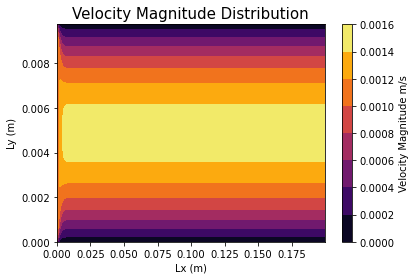

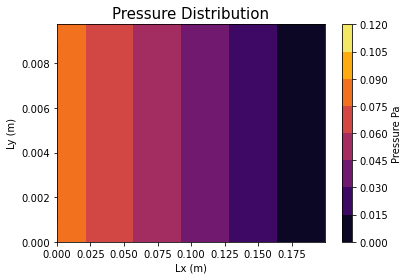

In [7]:
vx,vy,p,vmag = FluidFlowChannel(Lx,Ly,Nx,Ny,mu,rho,vin,scaleFactor,max_its,tol)